In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn

import safetensors
from accelerate import notebook_launcher

import einops

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, simple_train_model


from models.vq_brain import SoundStream
from transformers import GPT2Tokenizer


In [2]:
import torch
from vector_quantize_pytorch import FSQ

levels = [8,5,5,5] # see 4.1 and A.4.1 in the paper
quantizer = FSQ(levels)

x = torch.randn(2, 1024, 4) # 4 since there are 4 levels
xhat, indices = quantizer(x)

print(xhat.shape)    # (1, 1024, 4) - (batch, seq, dim)
print(indices.shape) # (1, 1024)    - (batch, seq)

assert xhat.shape == x.shape
assert torch.all(xhat == quantizer.indices_to_codes(indices))

torch.Size([2, 1024, 4])
torch.Size([2, 1024])


In [3]:
config = dict(C=256, D=5, n_electrodes=256, levels=[8, 8, 8, 6, 5])
model = SoundStream(**config)
count_parameters(model)


x = torch.zeros(16, 256, 256)
loss, pred = model(x)
pred.shape

model.get_quantize_vectors(x)[1].shape

self.codebook_size 15360
Total: 24.94M, Trainable: 24.94M


torch.Size([16, 256, 5])

### Run training pipeline

In [4]:
project_name = 'vq_brain'

train_config = TrainConfig(exp_name='spikes_minmax_fsq_100M_ws_256',
                           mixed_precision=False, 
                           batch_size=32, 
                           num_workers=3, 
                           pin_memory=True, 
                           eval_interval=1000, 
                           learning_rate=3e-4,
                           weight_decay=0, 
                           grad_clip=100, 
                           lr_decay_iters=50_000, 
                           warmup_iters=100
                          )
# peter path
# data_path = Path(r'C:\Users\peter\alvi\brain2text\competitionData')

# data_path = Path(r'D:\Work\brain-to-text-competition\data\competitionData')

data_path = Path("/drive/data/competitionData")
save_folder = Path("/drive/logs/kovalev")

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


train_dataset = BrainDataset(data_path / 'train', tokenize_function=get_tokenizer(tokenizer), max_input_len=256)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), max_input_len=256)

# indices = torch.arange(128)
# train_dataset = torch.utils.data.Subset(test_dataset, indices)
# test_dataset = torch.utils.data.Subset(test_dataset, indices)

# model = torch.compile(model)
args = (model, (train_dataset, test_dataset), train_config, project_name, save_folder)
notebook_launcher(run_train_model, args, num_processes=1)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Runed processing of the  /drive/data/competitionData/train
len: 8800
max input len 256
Runed processing of the  /drive/data/competitionData/test
len: 880
max input len 256
Launching training on one GPU.


/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
wandb: Currently logged in as: koval_alvi. Use `wandb login --relogin` to force relogin


Device for training:  cuda
Num devices:  1
Completed initialization of scheduler
*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

KeyboardInterrupt: 

In [5]:

model = model._orig_mod

AttributeError: 'SoundStream' object has no attribute '_orig_mod'

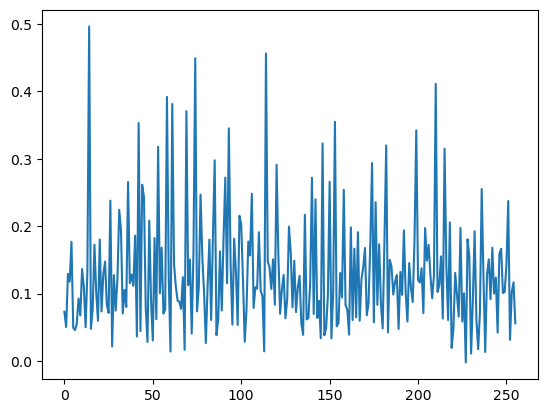

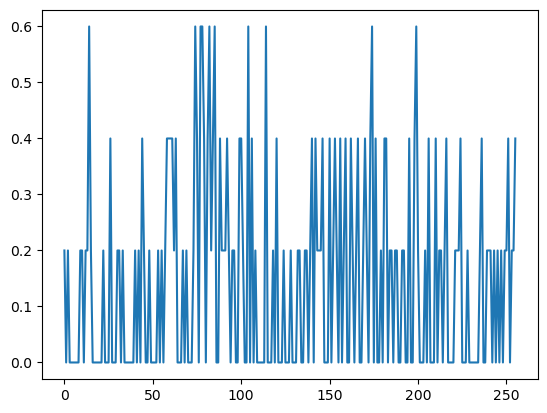

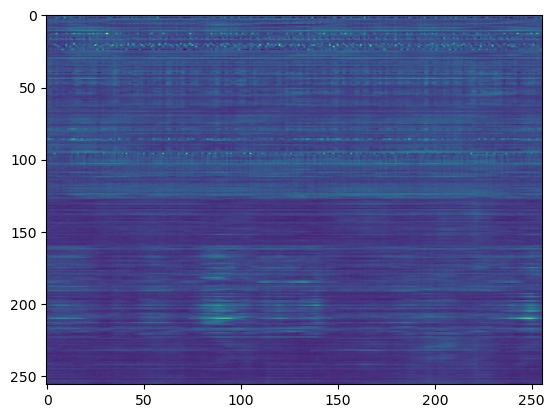

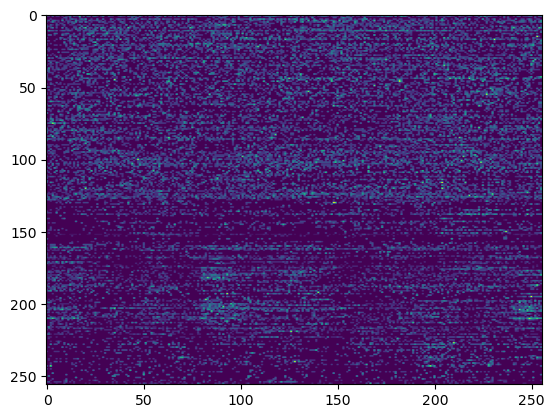

In [8]:
x = train_dataset[10][0]

x = torch.from_numpy(x[None, :]).to('cuda')

e = model.encoder(x)
quantized, indices = model.quantizer(e)

y = model(x)[1]

x = x.detach().cpu()[0]
y = y.detach().cpu()[0]

import matplotlib.pyplot as plt
plt.plot(y[:, 20])
plt.show()
plt.plot(x[:, 20])
plt.show()
plt.imshow(y.T, aspect='auto')
plt.show()
plt.imshow(x.T, aspect='auto')